<a href="https://colab.research.google.com/github/markerenberg/Toxic-Comment-Classification/blob/master/RandomForest_SMOTE_SMBO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check if GPU is enabled
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
##
## =======================================================
## Mark Erenberg 
## Toxic Comment Classification Challenge
## =======================================================
##

# Objective: Create a model which predicts a probability of each type of toxicity for each comment.

# import dependencies and files

import os
import time
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse import hstack
import itertools
import matplotlib.pyplot as plt
import re
import tempfile
import warnings
import ast

import lightgbm as lgb
import xgboost as xgb

import nltk
#nltk.download()
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

import gensim
import gensim.models.keyedvectors as word2vec
from gensim.models.fasttext import FastText
from gensim.models.word2vec import Word2Vec

import spacy
import en_core_web_sm
spacy_nlp = en_core_web_sm.load()
spacy_nlp = spacy.load('en_core_web_sm')
from spacy.lemmatizer import Lemmatizer

from collections import Counter, defaultdict

from sklearn import utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.callbacks import Callback

from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline


################### Data Loading ###################
#os.chdir('C:\\Users\\marke\\Downloads\\Toxic Classification')
train = pd.read_csv('train.csv').fillna('')
test = pd.read_csv('test.csv').fillna('')

train_text = train[['id','comment_text']].drop_duplicates()
df = pd.concat([train_text,test],axis=0,ignore_index=True)

################### Data Cleaning ####################
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
cv = CountVectorizer(min_df=0., max_df=1.)
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Simple way to get the number of occurence of a regex
def count_regexp_occ(regexp="", text=None):
    return len(re.findall(regexp, text))

# Determine if file words exist:
#print(len(df[df['comment_text'].str.contains('jpg')]))
#print(len(df[df['comment_text'].str.contains('jpeg')]))
#print(len(df[df['comment_text'].str.contains('http')]))
#print(len(df[df['comment_text'].str.contains('pdf')]))
#print(len(df[df['comment_text'].str.contains('html')]))

# Remove non-alphabetic characters and split tokens by spaces/newlines
def clean_document(doc,use_stop=True):
    # 1) Convert string to lower
    #doc = bytes(doc.lower(), encoding="utf-8")
    doc = doc.lower()
    # 2) Replace contracion patterns
    cont_patterns = [
    (r'(W|w)on\'t', r'will not'),
    (r'(C|c)an\'t', r'can not'),
    (r'(I|i)\'m', r'i am'),
    (r'(A|a)in\'t', r'is not'),
    (r'(\w+)\'ll', r'\g<1> will'),
    (r'(\w+)n\'t', r'\g<1> not'),
    (r'(\w+)\'ve', r'\g<1> have'),
    (r'(\w+)\'s', r'\g<1> is'),
    (r'(\w+)\'re', r'\g<1> are'),
    (r'(\w+)\'d', r'\g<1> would'),
    ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
    for (pattern, repl) in patterns:
        doc = re.sub(pattern, repl, doc)
    # 3) Remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]+', '', doc)
    #doc = doc.encode('utf-8')
    #doc = str(doc,'utf-8').strip()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    if use_stop:
      # filter stopwords out of document
      filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
      filtered_tokens = tokens
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    #doc = ' '.join(tokens)
    return doc

# Lemmaitze comments:
def lemmatize_comment(comment):
        doc = spacy_nlp(comment)
        return [token.lemma_ for token in doc if token.lemma_ != '-PRON-' ]         


## Clean and lemmatize comments
#df['clean_comments'] = [clean_document(x) for x in df['comment_text']]
#df['clean_comments_list'] = df['clean_comments'].apply(lambda x: x.split())
#df['clean_lemmed'] = [lemmatize_comment(x) for x in df['clean_comments']]
#df['clean_lemmed_str'] = df['clean_lemmed'].apply(lambda x: " ".join(x))
#train['clean_comments'] = [clean_document(x) for x in train['comment_text']]
#train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
#train['clean_lemmed'] = [lemmatize_comment(x) for x in train['clean_comments']]
#train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))

## Write to csv for download
#from google.colab import drive
#drive.mount('/content/drive')
#train['clean_comments'].to_csv('train_clean_comments.csv',sep=',',index=False)
#train['clean_lemmed'].to_csv('train_clean_lemmed.csv',sep=',',index=False)

## Read from csv
train_clean_comments = pd.read_csv('train_clean_comments.csv',header=None)
train_clean_lemmed = pd.read_csv('train_clean_lemmed.csv',header=None)

## Transform cleaned/lemmed strings
train['clean_comments'] = train_clean_comments[0].apply(lambda x: str(x))
train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
train['clean_lemmed'] = train_clean_lemmed[0].apply(lambda x: ast.literal_eval(x))
train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [0]:
### SPELL CHECK BABBYYY

# Load word2vec model pre-trained on Google News corpus (3 billion running words) 
google = api.load('word2vec-google-news-300')

words = google.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i
WORDS = w_rank

def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))


## Spell Check Function
def spell_check(doc):
    doc = doc.lower()
    doc = re.sub('[^a-zA-Z ]+', '', doc)
    doc_list = doc.split()
    for ind in range(len(doc_list)):
        doc_list[ind] = correction(doc_list[ind])
    return " ".join(doc_list)

In [5]:
################### Compare with baseline TF-IDF features ###################

# TF-IDF Vectorizer
train_text = train['clean_lemmed_str']

word_vectorizer = TfidfVectorizer(
    #min_df = 3,
    #max_df = 0.9,
    sublinear_tf=True,
    #smooth_idf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=20000)
word_vectorizer.fit(train_text)
train_word_features = word_vectorizer.transform(train_text)

char_vectorizer = TfidfVectorizer(
    #min_df = 3,
    #max_df = 0.9,
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=20000)
char_vectorizer.fit(train_text)
train_char_features = char_vectorizer.transform(train_text)

tfidf_features = hstack([train_char_features, train_word_features]).tocsr()
#train_tfidf_features = train_word_features.tocsr()

# Create features about type of text and category of text
def add_features(df):
    # Get length in words and characters
    df["word_count"] = df["comment_text"].apply(lambda x: len(x.split()))
    df["word_len_avg"] = df["comment_text"].apply(lambda x: np.mean([len(x) for x in x.split()]))
    df["word_len_std"] = df["comment_text"].apply(lambda x: np.std([len(x) for x in x.split()]))
    df["char_count"] = df["comment_text"].apply(lambda x: len(x))
    # Create count variables to see if any are useful
    df["upper_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[A-Z]", x)) /df['char_count']*100
    df["number_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[0-9]", x)) / df["char_count"] *100
    df["excl_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"!", x)) / df["char_count"] *100
    df["quest_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\?", x)) / df["char_count"] *100
    df["equals_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"=", x)) / df["char_count"] *100
    df["punct_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[.!\?=+#*|~-]", x)) / df["char_count"] *100
    df["you_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\W[Yy]ou\W", x)) / df["word_count"] *100
    df["nb_fuck"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ff][uU][cC][Kk]", x))
    df["nb_kill"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[kK][iI][lL][lL]", x))
    df["nb_suck"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ss]\S{2}[Kk]", x))
    df["nb_dick"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[dD]ick", x))
    df["nb_penis"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][eE][nN][iI][sS]", x))
    df["nb_pussy"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][uU][sS][sS][yY]", x))
    df["nb_cock"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC]ock", x))
    df["8==D"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"8=+D", x))
    df["nb_gay"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[gG][aA][yY]", x))
    df["nb_bitch"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[bB][iI][tT][cC][hH]", x))
    df["nb_cunt"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC][uU][nN][tT]", x))
    df["nb_shut_up"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[sS][hH][uU][tT]\s[uU][pP]", x))
    df["nb_mother"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\Wmother\W", x))
    df["nb_ng"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\Wnigger\W", x))
    df["nb_ng_2"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\Wnigga\W", x))
    df["nb_fat"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\W[Ff][aA][tT]\W", x))
    return

def pos_tagging(df):
    df["comment_raw"] = df["comment_text"].apply(lambda x: re.sub(r'[\n\r\t\r\n]',r' ',x,re.I|re.U))
    df["POS"] = df["comment_raw"].apply(lambda x: [token.pos_ for token in spacy_nlp(x)])
    return
    
def pos_features(df):
    # Get number of proper nouns
    df["PROPN"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'PROPN']))
    df["ADJ"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'ADJ']))
    df["INTJ"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'INTJ']))
    df["SYM"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'SYM']))
    return

## Create features
add_features(train)
pos_tagging(train)
pos_features(train)

## Look for duplicate comments
"""
Defining duplicate as: any time a comment appears more than twice.
"""

comment_counts = train['clean_comments'].value_counts().to_dict()
train['is_duplicate'] = train['clean_comments'].apply(lambda x: int(comment_counts[x]>1))

#print(train.loc[train['is_duplicate']==1,class_names].sum(axis=0))

## Look for spam comments
"""
Defining spam as: any comment that has the same sentence repeated twice.
"""
# Note NLTK tokenizer uses period/excl/quest followed by space to distinguish sentences
train['comment_list'] = train['comment_text'].apply(lambda x: (clean_document(x,use_stops=True)).split())

def count_duplicates(seq): 
    '''
    takes as argument a sequence and returns the number of duplicate elements
    ex: count_duplicates(["hello world.","hello world.","hello world."]) -> 2
    ex: count_duplicates(["hello world","fuck disneyland","hello world"]) -> 1
    '''
    return len(seq) - len(set(seq))

def count_non_duplicates(seq):
  '''
  takes as argument a list of words, and returns the percentage of words that are duplicates
  '''
  if len(set(seq)) == 0: return 0
  count_dict = Counter(seq)
  dup_words = [word for (word,count) in count_dict.items() if count >= 2]
  return len(dup_words)/len(set(seq))
  
train['dup_words'] = train['comment_list'].apply(lambda x: count_non_duplicates(x))
#print(train.loc[train['is_spam']==1,class_names].sum(axis=0))

meta_features = train.drop(['id','comment_text','comment_raw','POS','clean_comments','clean_comments_list','clean_lemmed','clean_lemmed_str','sentence_list','repeated_sentences','comment_list']+class_names,axis=1,inplace=False,errors='ignore')
train_features = hstack([sparse.csr_matrix(meta_features.values), tfidf_features]).tocsr()



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [0]:
# Set parameters
lgb_params = {
    "objective": "binary",
    'metric': 'map',
    #'is_unbalance': True,
    "boosting_type": "gbdt",
    "verbosity": -1,
    "num_threads": -1,
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8,
    "learning_rate": 0.1,
    "reg_lambda":0,
    "num_leaves": 31,
    "verbose": -1
}

xgb_params = {
    "objective": "binary:logistic",
    'eval_metric': 'map',
    "booster": "gbtree",
    "verbosity": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "learning_rate": 0.1,
    "lambda":1,
    "num_leaves": 31
}

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Ratio:  0.025  | mean AUC:  0.987


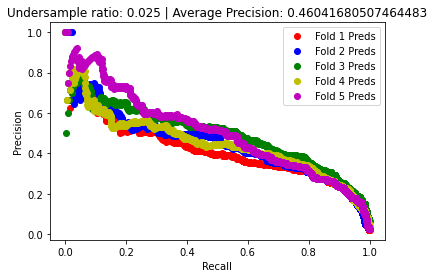

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Ratio:  0.05  | mean AUC:  0.9864


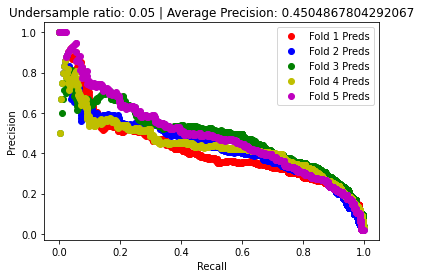

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Ratio:  0.1  | mean AUC:  0.9864


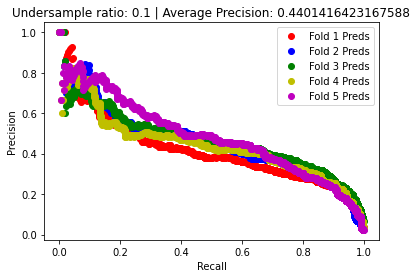

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Ratio:  0.15  | mean AUC:  0.9867


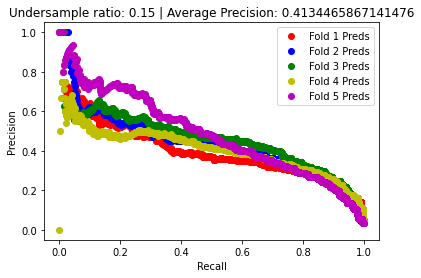

In [7]:
##### Investigating class imbalance + improving recall #####

resp = 'severe_toxic'
training_labels = train[resp]
seed = 1234
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
use_lgb=False

## Over_sampling and under_sampling
#over_ratios = [0.05,0.1,0.2]
under_ratios = [0.025,0.05,0.1,0.15]

for ratio in under_ratios:
  # Define new re-sampled data
  class_pred = np.zeros(train_features.shape[0])
  # Use 5-fold cross-validation to evaluate performance at given over-sampling ratio.
  auc,precision,recall,thresholds = [],[],[],[]
  for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
    # Define pipeline to oversample, undersample, and then cross-validate
    #over = SMOTE(sampling_strategy=0.025,k_neighbors=10)
    #under = TomekLinks(sampling_strategy='majority')
    under = RandomUnderSampler(sampling_strategy=ratio)
    #steps = [('over', over), ('under', under), ('model', model)]
    #pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    X_re, y_re = under.fit_resample(train_features[trn_idx],training_labels[trn_idx])
    #X_re, y_re = under.fit_resample(X_re,y_re)    
    if use_lgb:
      trn_lgbset = lgb.Dataset(train_features[trn_idx], free_raw_data=False)
      trn_lgbset.set_label(training_labels[trn_idx])
      lgb_rounds = 500
      #weight_ratio = np.sum(training_labels[trn_idx] == 0) / np.sum(training_labels[trn_idx] == 1)
      #lgb_params['scale_pos_weight'] = weight_ratio
      model = lgb.train(params=lgb_params,
                        train_set=trn_lgbset, 
                        num_boost_round=lgb_rounds,
                        valid_sets=[lgb.Dataset(train_features[val_idx], free_raw_data=False)],
                        early_stopping_rounds=50,
                        verbose_eval=0)
      class_pred[val_idx] = model.predict(train_features[val_idx], num_iteration=model.best_iteration)
    else:
      dtrain = xgb.DMatrix(X_re,label=y_re) 
      dval =  xgb.DMatrix(train_features[val_idx],label=training_labels[val_idx]) 
      watchlist = [(dtrain,'train'), (dval, 'valid')]
      xgb_rounds=200
      #weight_ratio = np.sum(X_re == 0) / np.sum(y_re == 1)
      #print("Weight ratio: ",weight_ratio)
      #xgb_params['scale_pos_weight'] = weight_ratio 
      model = xgb.train(params=xgb_params,
                        dtrain=dtrain,
                        num_boost_round=xgb_rounds,
                        evals=watchlist,
                        early_stopping_rounds=50,
                        verbose_eval=False)
      class_pred[val_idx] = model.predict(xgb.DMatrix(train_features[val_idx]), ntree_limit = model.best_ntree_limit)
    auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
    prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
    precision.append(prec)
    recall.append(recal)
    thresholds.append(thresh)
  # Print out mean AUC score
  print("Ratio: ",str(ratio),' | mean AUC: ',str(round(np.mean(auc),4)))
  # Plot precision-recall curve
  
  plt.figure()
  plt.plot(recall[0], precision[0], 'ro', linewidth=2,label='Fold 1 Preds')
  plt.plot(recall[1], precision[1], 'bo', linewidth=2,label='Fold 2 Preds')
  plt.plot(recall[2], precision[2], 'go', linewidth=2,label='Fold 3 Preds')
  plt.plot(recall[3], precision[3], 'yo', linewidth=2,label='Fold 4 Preds')
  plt.plot(recall[4], precision[4], 'mo', linewidth=2,label='Fold 5 Preds')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Undersample ratio: '+str(ratio)+' | Average Precision: '+str(average_precision_score(training_labels,class_pred,average='weighted')))
  plt.legend()
  plt.show()


In [0]:
##### Bayesian Hyperparameter Tuning for LightGBM/XGBoost #####

warnings.filterwarnings("ignore")

# Define variables for CV
#class_names = ['severe_toxic', 'threat', 'identity_hate']
seed = 1234
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
class_pred = np.zeros(train_features.shape[0])
auc,precision,recall,thresholds = [],[],[],[]
use_lgb = False

# Define response class
resp = 'severe_toxic'
training_labels = train[resp]

### Define functions for Bayesian Hyperparameter Optimization (SMBO using TPE)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, make_scorer

# 1) Define objective 

def objective(params):
    time1 = time.time()
    if use_lgb:
      params = {
          'learning_rate': params['learning_rate'],
          'bagging_fraction': params['bagging_fraction'],
          'feature_fraction': params['feature_fraction']}
    else:
        params = {
          'learning_rate': params['learning_rate'],
          'subsample': params['bagging_fraction'],
          'colsample_bytree': params['feature_fraction']}
    print("\n############## New Run ################")
    print(f"params = {params}")
    score_mean = 0
    class_pred = np.zeros(train_features.shape[0])

    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
      if use_lgb:
        trn_lgbset = lgb.Dataset(train_features[trn_idx], free_raw_data=False)
        trn_lgbset.set_label(training_labels[trn_idx])
        clf = lgb.train(params=params,
                        train_set=trn_lgbset, 
                        num_boost_round=lgb_rounds,
                        valid_sets=[lgb.Dataset(train_features[val_idx], free_raw_data=False)],
                        early_stopping_rounds=50,
                        verbose_eval=0)
        class_pred[val_idx] = clf.predict(train_features[val_idx], num_iteration=clf.best_iteration)
      else:
        dtrain = xgb.DMatrix(train_features[trn_idx],label=training_labels[trn_idx]) 
        dval =  xgb.DMatrix(train_features[val_idx],label=training_labels[val_idx]) 
        watchlist = [(dtrain,'train'), (dval, 'valid')]
        xgb_rounds=100 
        clf = xgb.train(params=params,
                          dtrain=dtrain,
                          num_boost_round=xgb_rounds,
                          evals=watchlist,
                          early_stopping_rounds=50,
                          verbose_eval=False)
        class_pred[val_idx] = clf.predict(xgb.DMatrix(train_features[val_idx]), ntree_limit = clf.best_ntree_limit)

      score = average_precision_score(training_labels[val_idx],class_pred[val_idx],average='weighted')
      score_mean += score
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    #gc.collect()
    print(f'Average Precision Score: {score_mean/splits}')
    return (score_mean / splits)


# 2) Define search space

space = {    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    #'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # Learning rate: Rate at which trees learn from error of previous models
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    
    # feature_fraction: Controls the subsampling of features used. Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    
    # bagging_fraction and bagging_freq: Enables bagging (subsampling) of the training data.  Smaller fractions and frequencies reduce overfitting.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1)
    
}

# 3) Specify Optimization algorithm
tpe_algo = tpe.suggest

# 4) Instantiate Trials object to track results
tpe_trials = Trials()

# Set hyperopt parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe_algo,
            trials = tpe_trials,
            

            max_evals=100)
# Print best parameters
best_params = space_eval(space, best)
print("BEST PARAMS: ", best_params)



############## New Run ################
params = {'learning_rate': 0.14536380278132133, 'subsample': 0.7191077940901183, 'colsample_bytree': 0.9328316071115921}
Total Time Run: 43.12
Average Precision Score: 0.40069073701264185

############## New Run ################
params = {'learning_rate': 0.12041525784834649, 'subsample': 0.6612534156571596, 'colsample_bytree': 0.999829520837061}
Total Time Run: 45.09
Average Precision Score: 0.3911176858201484

############## New Run ################
params = {'learning_rate': 0.04854235565106796, 'subsample': 0.8965348198222265, 'colsample_bytree': 0.6404990849885968}
Total Time Run: 34.97
Average Precision Score: 0.4047912537881378

############## New Run ################
params = {'learning_rate': 0.1516505248769574, 'subsample': 0.7799293312987889, 'colsample_bytree': 0.9480457111681099}
Total Time Run: 41.73
Average Precision Score: 0.3924256587060674

############## New Run ################
params = {'learning_rate': 0.09183400865042486, 

In [0]:
# Set LGBM parameters
# Set parameters
lgb_params = {
    "objective": "binary",
    'metric': 'map',
    #'is_unbalance': True,
    "boosting_type": "gbdt",
    "verbosity": -1,
    "num_threads": -1,
    'learning_rate': params['learning_rate'],
    'bagging_fraction': params['bagging_fraction'],
    'feature_fraction': params['feature_fraction'],
    "reg_lambda":0,
    "num_leaves": 31,
    "verbose": -1
}

xgb_params = {
    "objective": "binary:logistic",
    'eval_metric': 'map',
    "booster": "gbtree",
    "verbosity": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "learning_rate": 0.1,
    "lambda":1,
    "num_leaves": 31
}

# Make predictions for each fold in split, calculate evaluation metrics
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
  # Train Hyperoptimized LightGBM
  trn_lgbset = lgb.Dataset(train_features[trn_idx], free_raw_data=False)
  trn_lgbset.set_label(training_labels[trn_idx])
  model = lgb.train(params=params,
                    train_set=trn_lgbset, 
                    num_boost_round=lgb_rounds,
                    valid_sets=[lgb.Dataset(train_features[val_idx], free_raw_data=False)],
                    early_stopping_rounds=50,
                    verbose_eval=0)
  class_pred[val_idx] = model.predict(train_features[val_idx], num_iteration=model.best_iteration)
  auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
  prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
  precision.append(prec)
  recall.append(recal)
  thresholds.append(thresh)

# Print out mean AUC score
print("class: ",resp,' | mean AUC: ',str(round(np.mean(auc),4)))
# Plot precision-recall curve
plt.figure()
plt.plot(recall[0], precision[0], 'ro', linewidth=2,label='Fold 1 Preds')
plt.plot(recall[1], precision[1], 'bo', linewidth=2,label='Fold 2 Preds')
plt.plot(recall[2], precision[2], 'go', linewidth=2,label='Fold 3 Preds')
plt.plot(recall[3], precision[3], 'yo', linewidth=2,label='Fold 4 Preds')
plt.plot(recall[4], precision[4], 'mo', linewidth=2,label='Fold 5 Preds')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Class: '+resp+' | Average Precision: '+str(average_precision_score(training_labels,class_pred,average='weighted')))
plt.legend()
plt.show()